In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup, Normalization, StringLookup
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
df = pd.read_csv('/tf/School/Neural Networks and Deep Learning/NNDL-Assignments/hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# Question 1
### Splitting Data

In [5]:
df.drop(columns=['full_address', 'nearest_stn'], inplace=True)
df.head()

,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [6]:
#Split data
train_dataframe = df.loc[df['year'] <= 2020]
val_dataframe = df.loc[df['year'] == 2021]

train_dataframe = train_dataframe.drop(columns='year')
val_dataframe = val_dataframe.drop(columns='year')

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

We split the data by year as we want to use the historical data to predict the future data and not have it be affected by the future data. 

### Building model

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

all_inputs = [
    month,
    flat_model_type,
    storey_range,
    dist_to_nearest_stn,
    dist_to_dhoby,
    degree_centrality,
    eigenvector_centrality,
    remaining_lease_years,
    floor_area_sqm,
]

# Integer categorical features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ]
)

#### Custom $R^{2}$ function

In [8]:
import tensorflow.keras.backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [9]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)
model.compile(tf.keras.optimizers.Adam(0.05), "mse", metrics=[Accuracy(), r2_score])

#### Visualising model

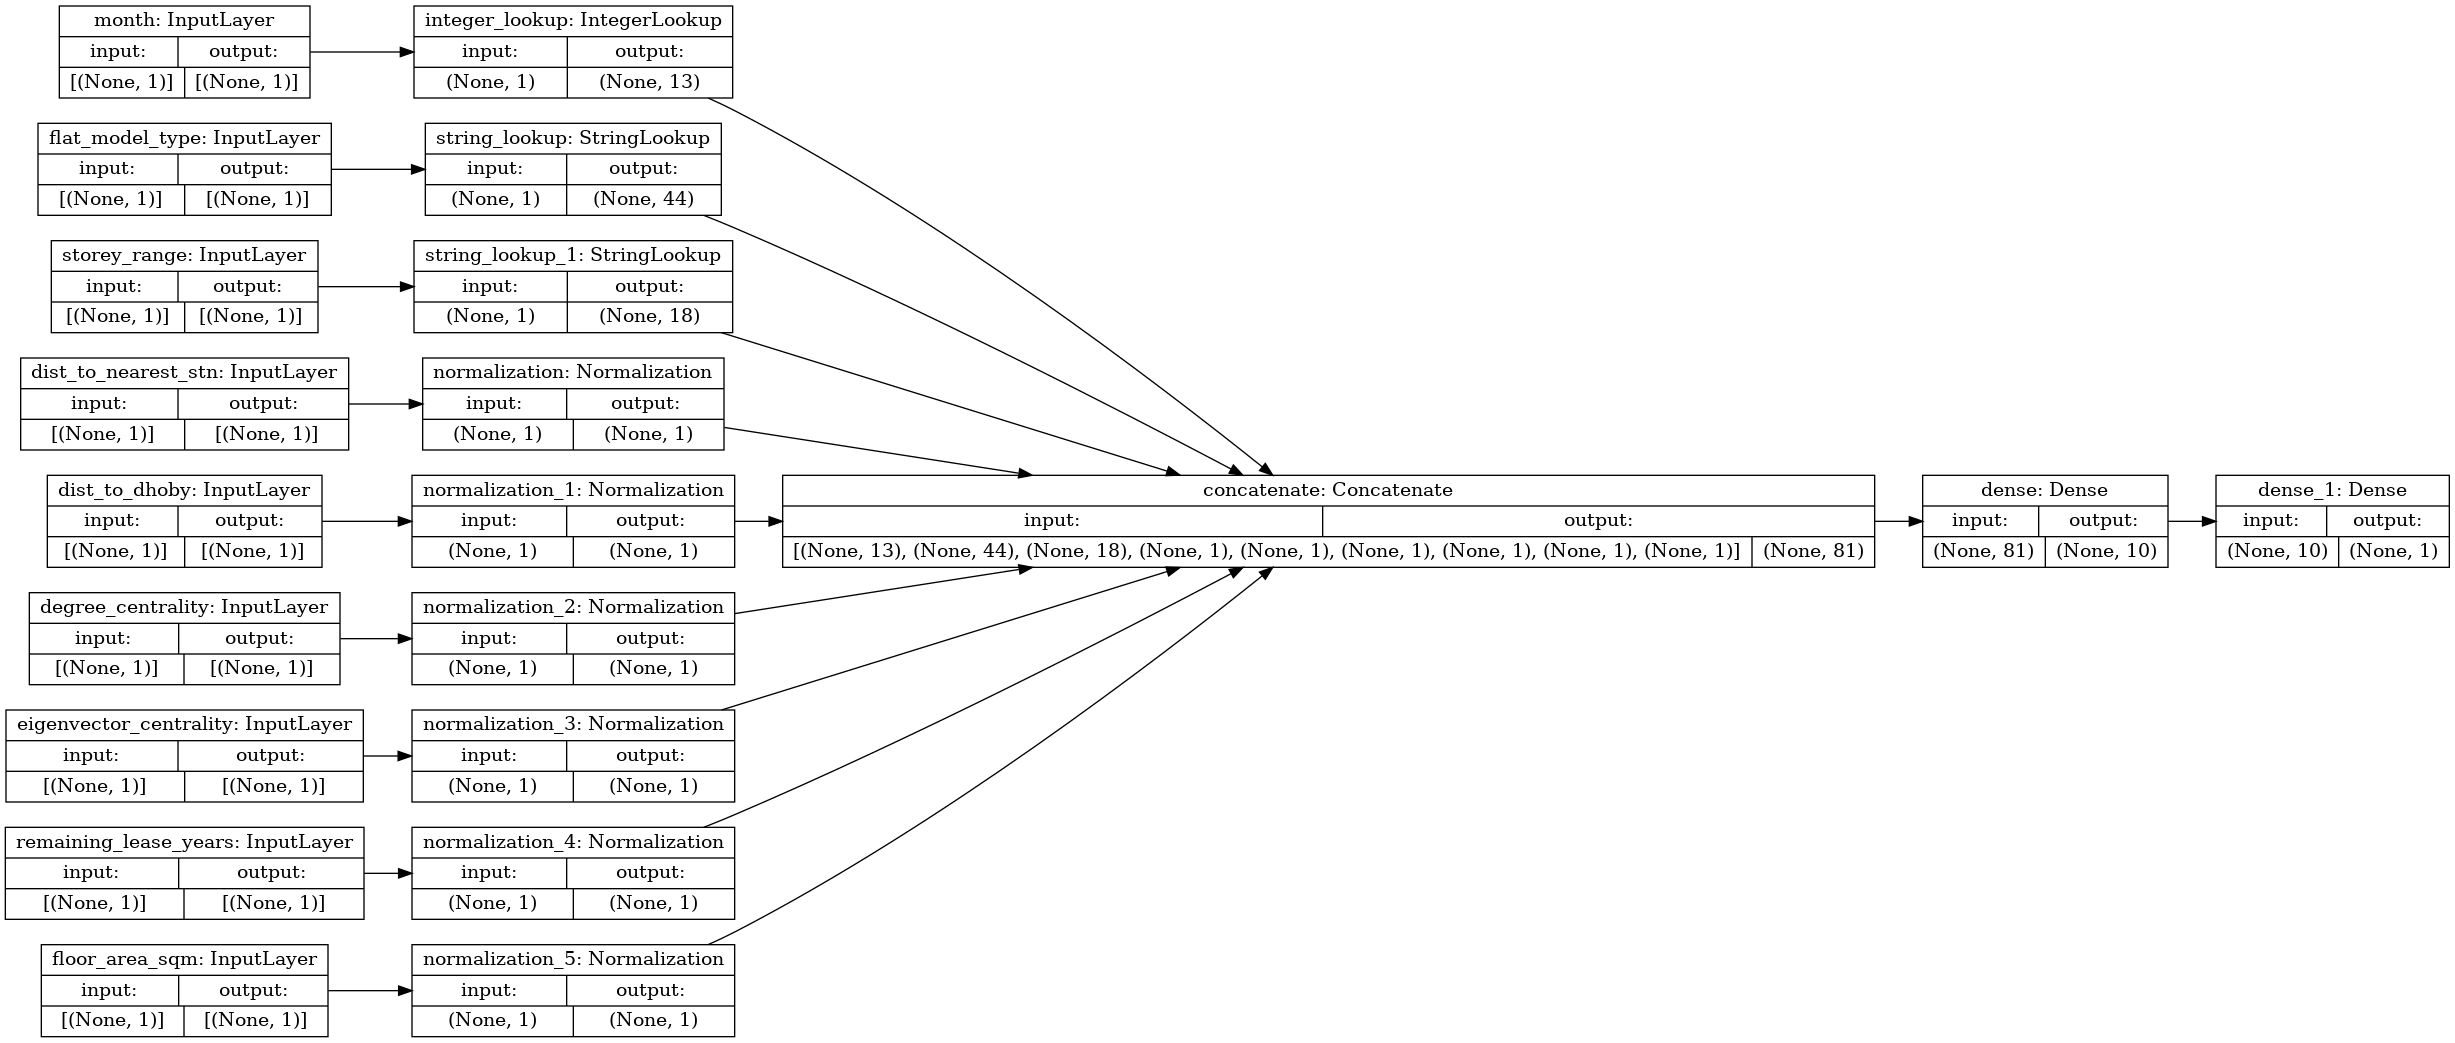

In [10]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

#### Model Checkpointing

In [11]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    mode='min')

### Training model

In [12]:
history = model.fit(
    train_ds,
    batch_size=128,
    epochs=100,
    callbacks=[model_checkpoint_callback],
    verbose=1,
    validation_data=val_ds,
    )

Epoch 1/100
683/683 [==============================] - 2s 1ms/step - loss: 189632856064.0000 - accuracy: 0.0000e+00 - r2_score: -7.1555 - val_loss: 175632465920.0000 - val_accuracy: 0.0000e+00 - val_r2_score: -5.8907
Epoch 2/100
683/683 [==============================] - 1s 1ms/step - loss: 69289803776.0000 - accuracy: 0.0000e+00 - r2_score: -1.9701 - val_loss: 40588152832.0000 - val_accuracy: 0.0000e+00 - val_r2_score: -0.5804
Epoch 3/100
683/683 [==============================] - 1s 1ms/step - loss: 10976583680.0000 - accuracy: 0.0000e+00 - r2_score: 0.5348 - val_loss: 11043729408.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.5734
Epoch 4/100
683/683 [==============================] - 1s 1ms/step - loss: 5546234368.0000 - accuracy: 0.0000e+00 - r2_score: 0.7641 - val_loss: 8589943808.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.6683
Epoch 5/100
683/683 [==============================] - 1s 1ms/step - loss: 4997148160.0000 - accuracy: 0.0000e+00 - r2_score: 0.7868 - val_loss:

Epoch 40/100
683/683 [==============================] - 1s 1ms/step - loss: 2969217792.0000 - accuracy: 0.0000e+00 - r2_score: 0.8722 - val_loss: 5322377216.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7922
Epoch 41/100
683/683 [==============================] - 1s 1ms/step - loss: 2912560640.0000 - accuracy: 0.0000e+00 - r2_score: 0.8747 - val_loss: 5465583616.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7856
Epoch 42/100
683/683 [==============================] - 1s 1ms/step - loss: 2872602112.0000 - accuracy: 0.0000e+00 - r2_score: 0.8765 - val_loss: 5446516224.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7868
Epoch 43/100
683/683 [==============================] - 1s 1ms/step - loss: 2844142592.0000 - accuracy: 0.0000e+00 - r2_score: 0.8777 - val_loss: 5392062464.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7890
Epoch 44/100
683/683 [==============================] - 1s 1ms/step - loss: 2823554304.0000 - accuracy: 0.0000e+00 - r2_score: 0.8785 - val_loss: 532136

Epoch 79/100
683/683 [==============================] - 1s 1ms/step - loss: 2646538752.0000 - accuracy: 0.0000e+00 - r2_score: 0.8862 - val_loss: 5197367296.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7972
Epoch 80/100
683/683 [==============================] - 1s 1ms/step - loss: 2645232896.0000 - accuracy: 0.0000e+00 - r2_score: 0.8856 - val_loss: 5150697984.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7988
Epoch 81/100
683/683 [==============================] - 1s 1ms/step - loss: 2643582464.0000 - accuracy: 0.0000e+00 - r2_score: 0.8863 - val_loss: 5191761408.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.7965
Epoch 82/100
683/683 [==============================] - 1s 1ms/step - loss: 2642652672.0000 - accuracy: 0.0000e+00 - r2_score: 0.8862 - val_loss: 5058817536.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.8018
Epoch 83/100
683/683 [==============================] - 1s 1ms/step - loss: 2641345792.0000 - accuracy: 0.0000e+00 - r2_score: 0.8862 - val_loss: 510177

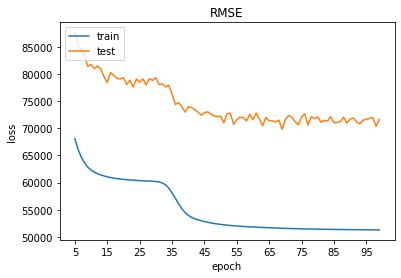

In [13]:
plt.plot(np.sqrt(history.history['loss'][5:]))
plt.plot(np.sqrt(history.history['val_loss'][5:]))
plt.title('RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0, 95, 10), [i for i in range(5, 100, 10)])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
lowest_error = np.argmin(history.history['val_loss'])
print(lowest_error)
print(history.history['val_r2_score'][lowest_error])

69
0.8086559176445007


As seen above, the lowest test error occurs in epoch 69 with a $R^{2}$ value of 0.80

### Using best model to predict values

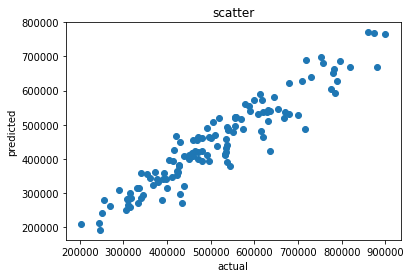

In [15]:
model.load_weights(checkpoint_filepath)
test = list(val_ds.as_numpy_iterator())[0]
predicted = model.predict(test[0])
actual = test[1]

plt.scatter(actual, predicted)
plt.title('scatter')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

# Question 2

### Adding Embedding layer

In [16]:
from math import floor

def encode_categorical_feature2(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    num_categories = len(lookup.get_vocabulary())
    encoded_feature = tf.keras.layers.Embedding(num_categories, floor(num_categories/2))(encoded_feature)
    return encoded_feature

In [21]:
# Integer categorical features
month_encoded = encode_categorical_feature2(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature2(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature2(storey_range, "storey_range", train_ds, True)

# Reshaping data
month_encoded = tf.keras.layers.Reshape((month_encoded.shape[1] * month_encoded.shape[2],))(month_encoded)
flat_model_type_encoded = tf.keras.layers.Reshape((flat_model_type_encoded.shape[1] * flat_model_type_encoded.shape[2],))(flat_model_type_encoded)
storey_range_encoded = tf.keras.layers.Reshape((storey_range_encoded.shape[1] * storey_range_encoded.shape[2],))(storey_range_encoded)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded,
        floor_area_sqm_encoded,
    ],
)

In [18]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model2 = keras.Model(all_inputs, output)
model2.compile(tf.keras.optimizers.Adam(0.05), "mse", metrics=[Accuracy(), r2_score])

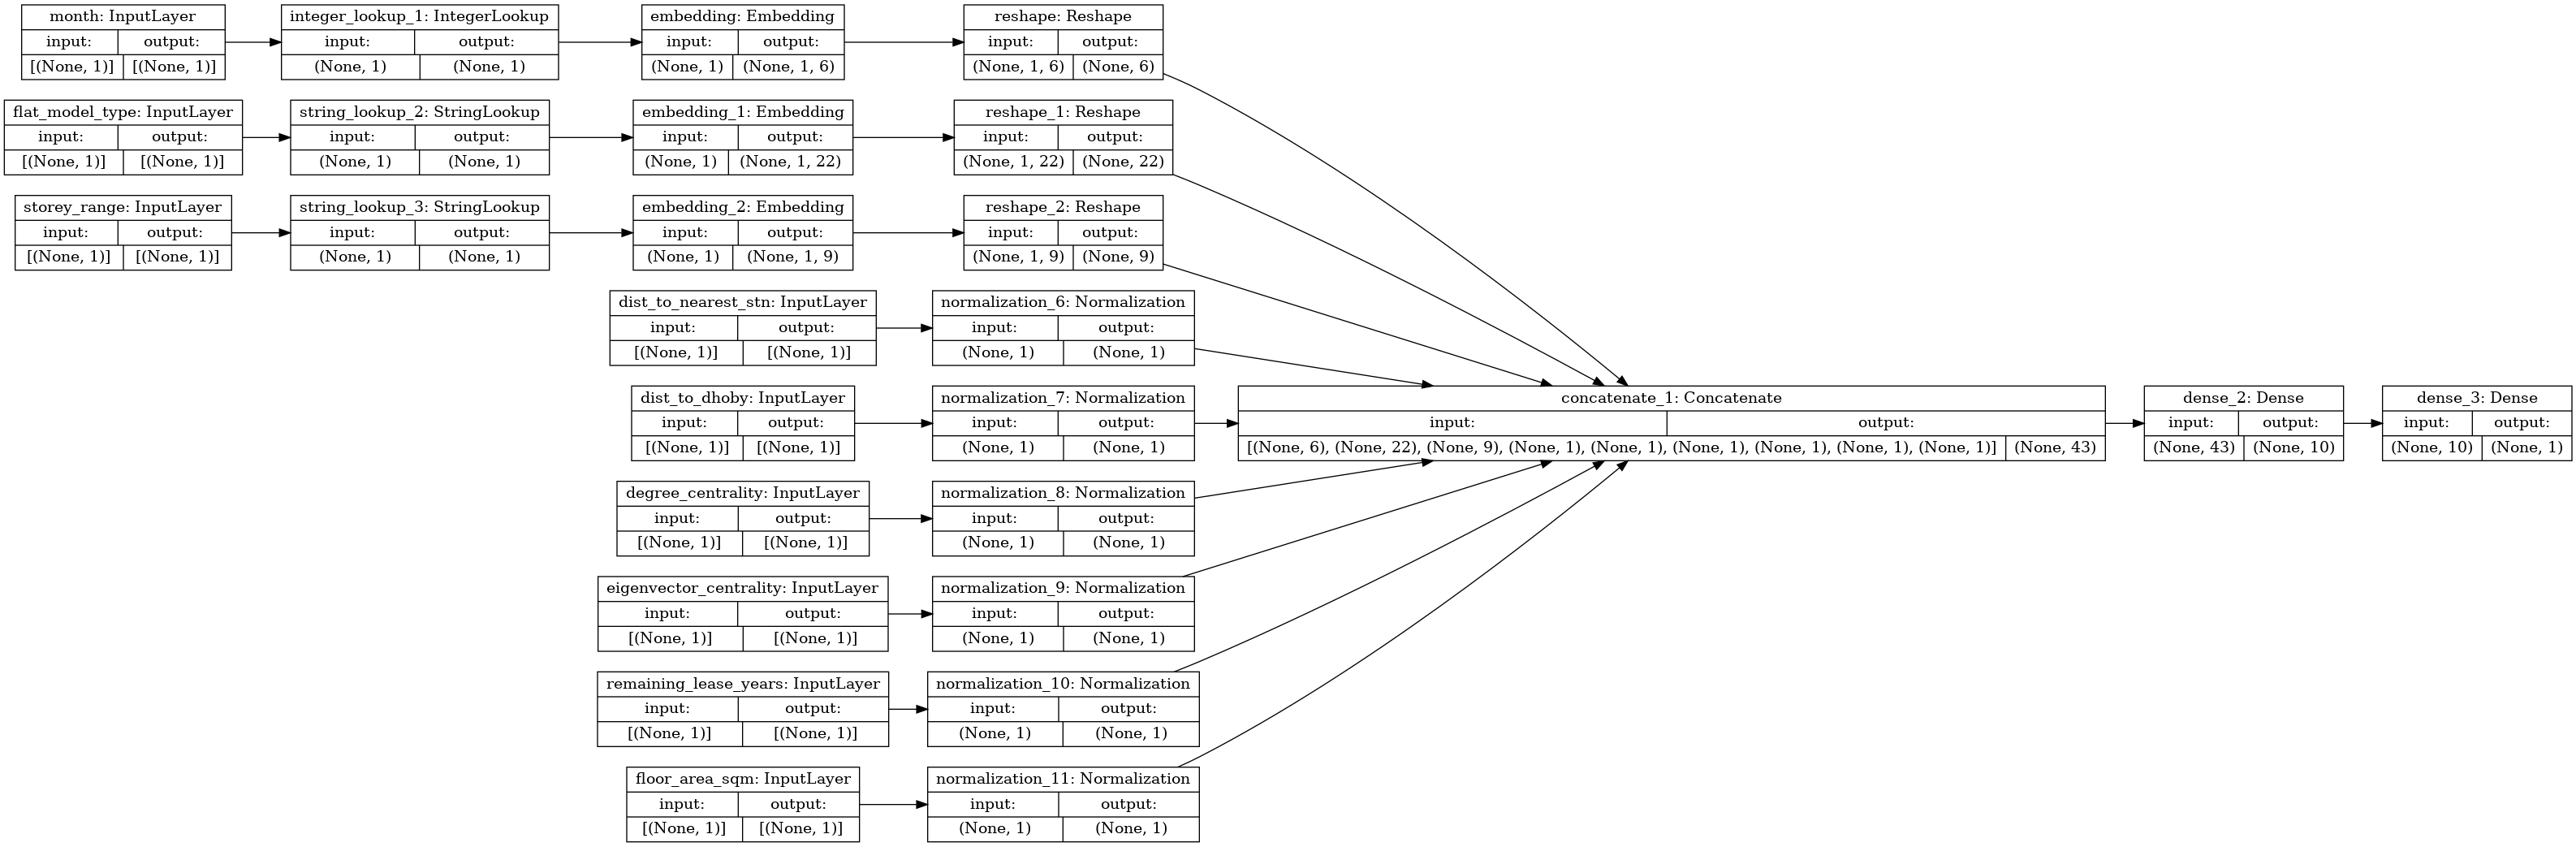

In [19]:
keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

#### Early stopping callback

In [22]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [23]:
history = model2.fit(
    train_ds,
    batch_size=128,
    epochs=100,
    callbacks=[model_checkpoint_callback, early_stop_callback],
    verbose=1,
    validation_data=val_ds,
    )

Epoch 1/100
683/683 [==============================] - 2s 1ms/step - loss: 45698519040.0000 - accuracy: 0.0000e+00 - r2_score: -0.9880 - val_loss: 11971067904.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.5386
Epoch 2/100
683/683 [==============================] - 1s 1ms/step - loss: 8064392192.0000 - accuracy: 0.0000e+00 - r2_score: 0.6555 - val_loss: 10196781056.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.6042
Epoch 3/100
683/683 [==============================] - 1s 1ms/step - loss: 7041561088.0000 - accuracy: 0.0000e+00 - r2_score: 0.6978 - val_loss: 9261534208.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.6400
Epoch 4/100
683/683 [==============================] - 1s 1ms/step - loss: 6283067392.0000 - accuracy: 0.0000e+00 - r2_score: 0.7313 - val_loss: 8203720704.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.6828
Epoch 5/100
683/683 [==============================] - 1s 1ms/step - loss: 5614465024.0000 - accuracy: 0.0000e+00 - r2_score: 0.7593 - val_loss: 7777119

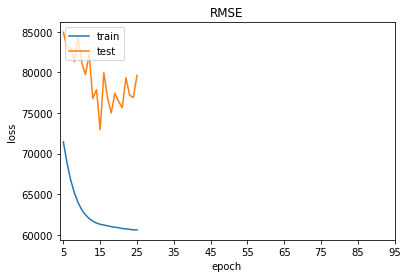

In [28]:
plt.plot(np.sqrt(history.history['loss'][5:]))
plt.plot(np.sqrt(history.history['val_loss'][5:]))
plt.title('RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0, 95, 10), [i for i in range(5, 100, 10)])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
lowest_error = np.argmin(history.history['val_loss'])
print(lowest_error)
print(history.history['val_r2_score'][lowest_error])

15
0.7933107614517212


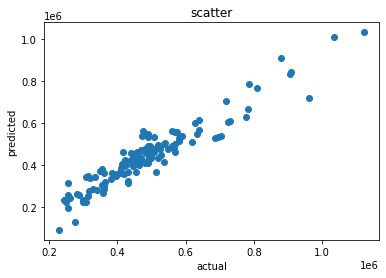

In [26]:
model2.load_weights(checkpoint_filepath)
test = list(val_ds.as_numpy_iterator())[0]
predicted = model2.predict(test[0])
actual = test[1]

plt.scatter(actual, predicted)
plt.title('scatter')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.show()

As we can see from the above, the model did reach its peak performance at an earlier epoch and the $R^2$ value is higher as well.

# Question 3

In [32]:
removed_feature = []
rmse = []
r2 = []

In [26]:
tf.keras.backend.clear_session()

# Integer categorical features
month_encoded = encode_categorical_feature2(month, "month", train_ds, False)

# String categorical features
flat_model_type_encoded = encode_categorical_feature2(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature2(storey_range, "storey_range", train_ds, True)

# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

month_encoded = tf.keras.layers.Reshape((month_encoded.shape[1] * month_encoded.shape[2],))(month_encoded)
flat_model_type_encoded = tf.keras.layers.Reshape((flat_model_type_encoded.shape[1] * flat_model_type_encoded.shape[2],))(flat_model_type_encoded)
storey_range_encoded = tf.keras.layers.Reshape((storey_range_encoded.shape[1] * storey_range_encoded.shape[2],))(storey_range_encoded)

In [107]:
encoded = [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        #degree_centrality_encoded, removed in round 1
        #eigenvector_centrality_encoded, removed in round 2
        remaining_lease_years_encoded,
        #floor_area_sqm_encoded,
    ]

all_features = layers.concatenate(encoded)

In [108]:
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model3 = keras.Model(all_inputs, output)
model3.compile(tf.keras.optimizers.Adam(0.05), "mse", metrics=[Accuracy(), r2_score])

history = model3.fit(
    train_ds,
    batch_size=128,
    epochs=100,
    callbacks=[model_checkpoint_callback, early_stop_callback],
    verbose=1,
    validation_data=val_ds,
)

removed_feature.append('Round 3: floor_area_sqm')
lowest_error = np.argmin(history.history['val_loss'])
r2.append(history.history['val_r2_score'][lowest_error])
rmse.append(history.history['val_loss'][lowest_error])

tf.keras.backend.clear_session()

Epoch 1/100
683/683 [==============================] - 2s 2ms/step - loss: 28921485312.0000 - accuracy: 0.0000e+00 - r2_score: -0.2207 - val_loss: 13126731776.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.4956
Epoch 2/100
683/683 [==============================] - 1s 2ms/step - loss: 9524311040.0000 - accuracy: 0.0000e+00 - r2_score: 0.5943 - val_loss: 11200500736.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.5669
Epoch 3/100
683/683 [==============================] - 1s 1ms/step - loss: 8593720320.0000 - accuracy: 0.0000e+00 - r2_score: 0.6321 - val_loss: 10234857472.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.6031
Epoch 4/100
683/683 [==============================] - 1s 1ms/step - loss: 8156665856.0000 - accuracy: 0.0000e+00 - r2_score: 0.6508 - val_loss: 10404080640.0000 - val_accuracy: 0.0000e+00 - val_r2_score: 0.5966
Epoch 5/100
683/683 [==============================] - 1s 1ms/step - loss: 7823307776.0000 - accuracy: 0.0000e+00 - r2_score: 0.6652 - val_loss: 11318

In [109]:
results = pd.DataFrame(data={
    'Feature': removed_feature,
    'r2': r2,
    'RMSE': rmse
})

results.head()

,Feature,r2,RMSE
0,control,0.823838,4.488620e+09
1,month,0.841078,4.068735e+09
2,flat_model_type,0.791326,5.365562e+09
3,storey_range,0.810840,4.823834e+09
4,dist_to_nearest_stn,0.786532,5.470250e+09


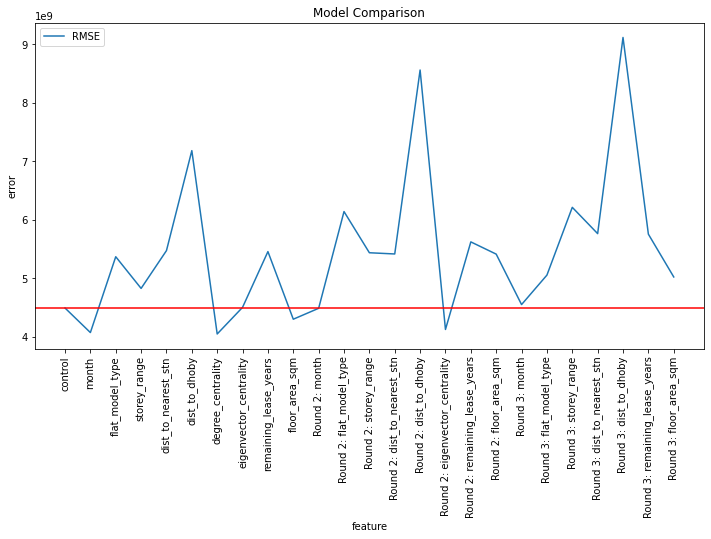

In [110]:
plt.figure(figsize=(12, 6), dpi=72)
plt.plot(results.RMSE)
plt.axhline(y=results.RMSE[0], color='r', linestyle='-')
plt.title('Model Comparison')
plt.ylabel('error')
plt.xlabel('feature')
plt.xticks(range(len(results.Feature)), results.Feature, rotation='vertical')
plt.legend(['RMSE'], loc='upper left')
plt.show()

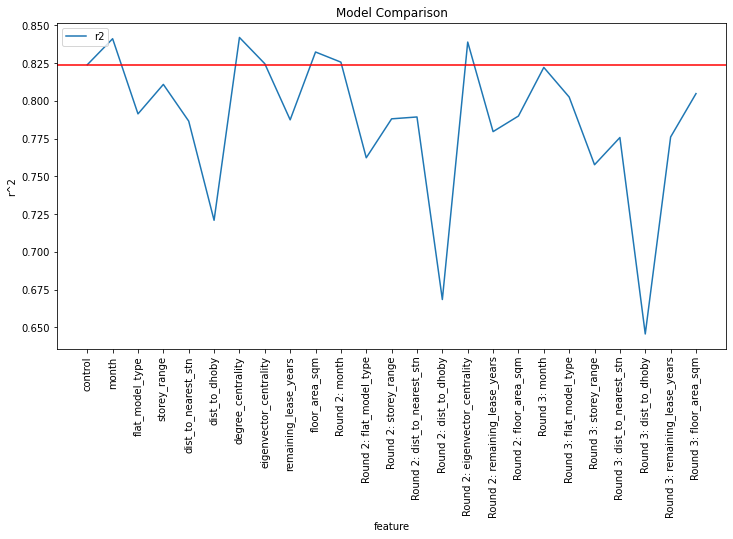

In [111]:
plt.figure(figsize=(12, 6), dpi=72)
plt.plot(results.r2)
plt.axhline(y=results.r2[0], color='r', linestyle='-')
plt.title('Model Comparison')
plt.ylabel('r^2')
plt.xlabel('feature')
plt.xticks(range(len(results.Feature)), results.Feature, rotation='vertical')
plt.legend(['r2'], loc='upper left')
plt.show()

As we can see above, after going through the RFE process, we have eliminated `degree_centrality` and `eigenvector_centrality` as the two variables that upon removing, the model has an increase in performance. It seems that being in a central location does not have that much of an importance to the price of HDB houses and that seems about right given that towns in Singapore are designed to be self-contained with their own slew of ammenities and entertainment areas. Hence there is no real need to travel outside of the town, causing the factor to not be that important for the model.

# Conclusion

We have seen from the experiments above that we can indeed predict a numerical value from a mix of numeric and categorical data after making the appropriate adjustments to the inputs and feeding it into the model. We have also seen how we can introduce custom metrics during the evaluation with the $R^2$ score and introduce stopping and saving callbacks to ensure that we extract the best model from the training phase. We have also gone through the RFE process to determine the optimal model for our use case. To determine which are the factors that lead to a price increase, we can look at the weights of the dense network to see which inputs the model has prioritised.